<a href="https://colab.research.google.com/github/vinayprabhu/GaitID-2-SquatID/blob/master/Ynet_classify_squats_acc_gyr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook walks you through the creation and performance testing of the Y-net architecture for motion-sensor based squat classification problem.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/gdrive')
##############################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
tf.keras.backend.clear_session()  # For easy reset of notebook state.

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Using TensorFlow backend.


In [0]:
os.chdir('/gdrive/My Drive/Colab Notebooks/Squat_classify')

In [0]:
X_gyr=np.load('squat_gyr_data.npy')
X_acc=np.load('squat_acc_data.npy')
y=np.load('participant_labels.npy')
X_acc=np.expand_dims(np.swapaxes(X_acc,1,2),3)
X_gyr=np.expand_dims(np.swapaxes(X_gyr,1,2),3)
print(X_gyr.shape,X_acc.shape,y.shape)

(587, 4, 250, 1) (587, 4, 250, 1) (587,)


In [0]:
from scipy.signal import resample
X_gyr_100=resample(X_gyr[:,0:4,:],100,axis=2)
X_acc_100=resample(X_acc[:,0:4,:],100,axis=2)
X_acc_100.shape,X_gyr_100.shape


((587, 4, 100, 1), (587, 4, 100, 1))

In [0]:
y-=y.min()
np.bincount(y)

array([34, 40,  9, 41, 27, 45, 24, 45, 44, 28, 30, 38, 30, 20, 30, 16,  8,
       20, 27, 31])

In [0]:
num_classes=len(np.unique(y))
num_classes

20

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=0)

for train_index, test_index in sss.split(X_acc, y):
   x_acc_train, x_acc_test = X_acc_100[train_index], X_acc_100[test_index]
   x_gyr_train, x_gyr_test = X_gyr_100[train_index], X_gyr_100[test_index]
   y_train, y_test = y[train_index], y[test_index]

Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)

print(X_acc.shape,X_gyr.shape,x_acc_train.shape)
#####################################################################################
acc_input = keras.Input(shape=(4,100,1), name='acc')  
acc_feat = layers.Conv2D(32,(1,4), activation='relu')(acc_input)
acc_feat_bn=layers.BatchNormalization()(acc_feat)
acc_feat_bn_pooled =layers.AveragePooling2D(pool_size=(4,3))(acc_feat_bn)


gyr_input = keras.Input(shape=(4,100,1), name='gyr')  #
gyr_feat = layers.Conv2D(32,(1,4), activation='relu')(gyr_input)
gyr_feat_bn=layers.BatchNormalization()(gyr_feat)

gyr_feat2 = layers.Conv2D(32,(1,4), activation='relu',padding='same')(gyr_feat_bn)
gyr_feat2_bn=layers.BatchNormalization()(gyr_feat2)

gyr_feat3_bn=layers.Add()([gyr_feat_bn, gyr_feat2_bn])
gyr_feat3_bn_pooled =layers.AveragePooling2D(pool_size=(4,3))(gyr_feat3_bn)

ag_concat = layers.concatenate([acc_feat_bn_pooled ,gyr_feat3_bn_pooled ])

ag_feat = layers.Conv2D(32,(1,4), activation='relu')(ag_concat)
ag_feat_bn=layers.BatchNormalization()(ag_feat)

ag_feat2 = layers.Conv2D(32,(1,4), activation='relu')(ag_feat_bn)
ag_feat2_bn=layers.BatchNormalization()(ag_feat2)

ag_flat=layers.Flatten()(ag_feat2_bn)
print(acc_feat_bn_pooled.shape ,gyr_feat3_bn_pooled.shape, ag_concat.shape,ag_flat.shape)

ag_128=layers.Dense(128)(ag_flat)
output_pred = layers.Dense(num_classes, activation='softmax', name='softmax_op')(ag_128)

# Instantiate an end-to-end model ingesting both Acc and Gyr
Y_net = keras.Model(inputs=[acc_input, gyr_input],
                    outputs=output_pred)
Y_net.compile(loss='categorical_crossentropy',
                     optimizer='rmsprop',
                     metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='Ynet_best.h5',
        save_best_only=True,
        monitor='val_accuracy',
        verbose=0)
]

history=Y_net.fit([x_acc_train,x_gyr_train], Y_train,
          batch_size=16,
          epochs=100,
          verbose=0,
          callbacks=callbacks,
          validation_split=0.15)

del Y_net
K.clear_session()

from tensorflow.keras.models  import load_model
Y_net=load_model('Ynet_best.h5')
score = Y_net.evaluate([x_acc_test,x_gyr_test], Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

(587, 4, 250, 1) (587, 4, 250, 1) (498, 4, 100, 1)
(None, 1, 32, 32) (None, 1, 32, 32) (None, 1, 32, 64) (None, 832)
Test loss: 1.7942819595336914
Test accuracy: 0.8202247023582458


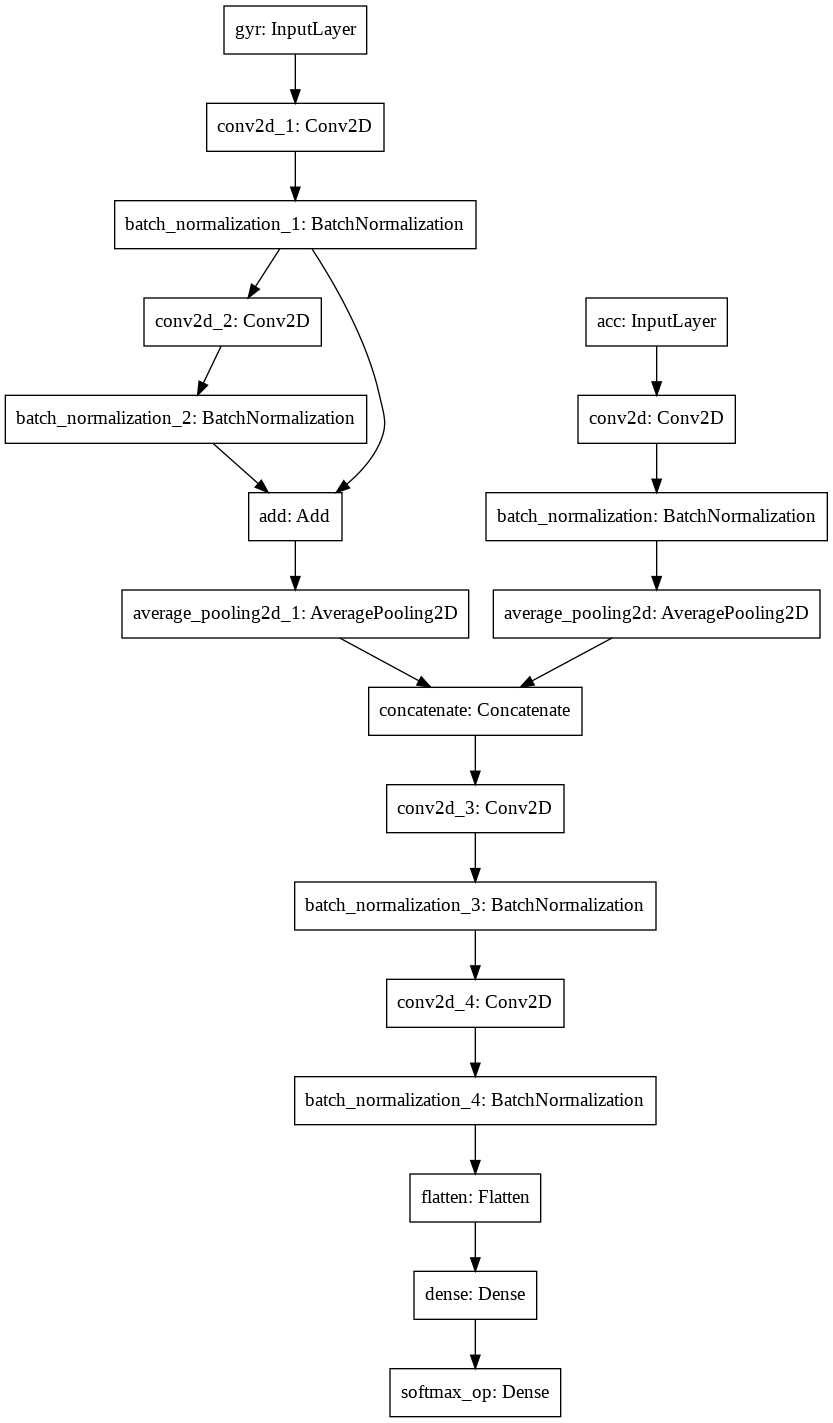

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(
    Y_net, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)